<h1>The purpose of this notebook is to mimic the FedAvg Algorithm used in <i>Communication-Efficient Learning of Deep Networks from Decentralized Data</i>, produce similar results, and gain coding experience in Federated Learning concepts</h1> For HW, compare IID vs non IID, and implement round robin style scheduling of clients compared to the "random" scheduling. If no change is seen then change the parameters to show the difference

In [2]:
# Import Global Dependencies
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

# Import Helper Libaries
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import random
import copy
import time

<h2>CNN Model Declaration</h2>

In [3]:
class CNN(nn.Module):
    def __init__(self, args):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=args.num_dimensions, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, args.num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1) 
        return x

<h2>Local Model Training</h2>

In [4]:
def client_update(clients, optimizer, training_loader, epochs):
    clients.train()
    for epoch in range(epochs):
        for batch_idx, (inputs, labels) in enumerate(training_loader):
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            output = clients(inputs)
            loss = nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
    return loss.item()

<h2>Global Aggregator</h2>

In [5]:
def global_aggregate(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k] for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

<h2>Model Evaluation</h2>

In [6]:
def model_evaluation(global_model, validation_loader):
    global_model.eval()
    loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            output = global_model(inputs)
            loss += nn.CrossEntropyLoss()(output, labels).item()  # Using the criterion
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss /= len(validation_loader.dataset)
    accuracy = correct / total

    return loss, accuracy

<h2>Federated Averaging Algorithm</h2>

In [7]:
def FedAvg(local_ws, clients):
    avg_w = {}
    for k in local_ws[0].keys():
        sum_w = torch.zeros_like(local_ws[0][k])
        for i in range(len(local_ws)):
            sum_w += torch.mul(local_ws[i][k], clients[i])
        avg_w[k] = torch.div(sum_w, sum(clients))
    return avg_w

<h2>Federated Training</h2>

<h3>Training using Random Scheduling</h3>

In [8]:
def random_training(global_model, args):
    clients = [CNN(args=args).to(args.device) for _ in range(args.total_clients)]
    for models in clients:
        models.load_state_dict(global_model.state_dict())
    
    opt = [optim.SGD(models.parameters(), lr=args.lr) for models in clients]

    round_losses, round_accuracies = [], []
    
    for round in range(args.total_rounds):
        start_time = time.time()
        clients_idx = np.random.permutation(args.total_clients)[:args.clients_per_round]
    
        client_losses = 0
        for i in range(args.clients_per_round):
            client_losses += client_update(clients[i], opt[i], training_loader[clients_idx[i]], args.local_epochs)
        
        global_aggregate(global_model, clients)
    
        avg_loss = client_losses / args.clients_per_round
        round_loss , round_accuracy = model_evaluation(global_model, validation_loader)

        round_losses.append(round_loss)
        round_accuracies.append(round_accuracy)
    
        end_time = time.time()
        round_time = end_time - start_time
    
        if (round % 50) == 0:
            print('Round {:3d}, Time (secs) {:.2f}: Average loss {:.4f}, Accuracy {:.4f}'.format(round + 1, round_time, round_loss, round_accuracy))
    return round_losses, round_accuracies

<h3>Training using Age Based Scheduling</h3>

In [9]:
def client_selection(clients, global_AOU, clients_AOU):
    idx_to_sort = np.where(clients_AOU != global_AOU)[0]
    clients_AOU_sorted = np.argsort(clients_AOU[idx_to_sort])
    
    selected_clients_idx = idx_to_sort[clients_AOU_sorted[:10]]

    return selected_clients_idx

In [10]:
def scheduled_training(global_model, args):
    clients = [CNN(args=args).to(args.device) for _ in range(args.total_clients)]
    for models in clients:
        models.load_state_dict(global_model.state_dict())
    
    opt = [optim.SGD(models.parameters(), lr=args.lr) for models in clients]
    global_AOU = 0
    clients_AOU = np.zeros(args.total_clients)
    round_losses, round_accuracies = [], []
    
    for round in range(args.total_rounds):
        start_time = time.time()

        if global_AOU == 0:
            clients_idx = (np.random.permutation(args.total_clients)[:args.clients_per_round])
        else:
            clients_idx = client_selection(clients, global_AOU, clients_AOU)

        global_AOU += 1
        client_losses = 0
        for i in range(args.clients_per_round):
            client_losses += client_update(clients[i], opt[i], training_loader[clients_idx[i]], args.local_epochs)
            clients_AOU[clients_idx[i]] = global_AOU
        
        global_aggregate(global_model, clients)
    
        avg_loss = client_losses / args.clients_per_round
        round_loss , round_accuracy = model_evaluation(global_model, validation_loader)

        round_losses.append(round_loss)
        round_accuracies.append(round_accuracy)
    
        end_time = time.time()
        round_time = end_time - start_time
        
        if (round % 50) == 0:
            print('Round {:3d}, Time (secs) {:.2f}: Average loss {:.4f}, Accuracy {:.4f}'.format(round + 1, round_time, round_loss, round_accuracy))
    return round_losses, round_accuracies

<h2>Hyperparameters for IID</h2>
The data is shuffled and then divided up across 100 clients each receiving 600 examples.

Training is done using Random Scheduling and Age Based Scheduling (See random_training and scheduled_training)

In [11]:
class FederatedSettings:
    def __init__(self, device, num_classes, num_dimensions, lr, total_rounds, verbose, total_clients, clients_per_round, local_batchsize, local_epochs):
        self.device = device
        self.num_classes = num_classes
        self.num_dimensions = num_dimensions
        
        self.lr = lr
        self.total_rounds = total_rounds                    
        self.verbose = verbose
        
        self.total_clients = total_clients
        self.clients_per_round = clients_per_round    
        self.local_batchsize = local_batchsize
        self.local_epochs = local_epochs

args = FederatedSettings(
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    num_dimensions = 1,                                # Input Shape
    num_classes = 10,                                  # Output Classes

    lr = 0.1,                                          # Learning Rate 
    total_rounds = 500,                                # Global Epochs or 'Communication rounds'    
    verbose = False,
    
    total_clients = 100,                               # Clients participating per round (K)
    clients_per_round = 10,                            # Fraction of Clients (C)
    local_batchsize = 10,                              # Local Minibatch size (B)
    local_epochs = 5,                                  # Local Epochs (E)
)

normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

training_dataset = datasets.MNIST('../data', train=True, download=True, transform=normalize)
validation_dataset = datasets.MNIST('./data', train=False, download = True, transform=normalize)

data_split = torch.utils.data.random_split(training_dataset, [int(training_dataset.data.shape[0] / args.total_clients) for _ in range(args.total_clients)])

training_loader = [torch.utils.data.DataLoader(x, batch_size=args.local_batchsize, shuffle=True) for x in data_split]
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=args.local_batchsize, shuffle=True)

global_model_random_IID = CNN(args=args).to(args.device)
global_model_scheduled_IID = CNN(args=args).to(args.device)

print("Beginning Random Scheduling IID Training")
random_losses_IID, random_accuracies_IID = random_training(global_model_random_IID, args)

print("\nBeginning Age Based Scheduling IID Training")
scheduled_losses_IID, scheduled_accuracies_IID = scheduled_training(global_model_scheduled_IID, args)

torch.save(global_model_random_IID, "FedAvg_Random-Schedule-IID")
torch.save(global_model_scheduled_IID, "FedAvg_AgeBased-Schedule-IID")

Beginning Random Scheduling IID Training
Round   1, Time (secs) 10.38: Average loss 0.2288, Accuracy 0.5519
Round  51, Time (secs) 10.43: Average loss 0.1486, Accuracy 0.9767
Round 101, Time (secs) 10.64: Average loss 0.1480, Accuracy 0.9823
Round 151, Time (secs) 10.75: Average loss 0.1476, Accuracy 0.9853
Round 201, Time (secs) 11.39: Average loss 0.1475, Accuracy 0.9871
Round 251, Time (secs) 10.33: Average loss 0.1473, Accuracy 0.9881
Round 301, Time (secs) 11.55: Average loss 0.1473, Accuracy 0.9884
Round 351, Time (secs) 10.26: Average loss 0.1472, Accuracy 0.9894
Round 401, Time (secs) 10.26: Average loss 0.1471, Accuracy 0.9902
Round 451, Time (secs) 10.20: Average loss 0.1471, Accuracy 0.9904

Beginning Age Based Scheduling IID Training
Round   1, Time (secs) 10.25: Average loss 0.2287, Accuracy 0.4864
Round  51, Time (secs) 10.15: Average loss 0.1487, Accuracy 0.9761
Round 101, Time (secs) 10.28: Average loss 0.1480, Accuracy 0.9821
Round 151, Time (secs) 10.86: Average loss 

<h2>Hyperparameters for Non-IID</h2>
The data is sorted by digit label, divided up into 200 'shards' of 300 examples, and then each client receieves 2 'shards'

Training is done using Random Scheduling and Age Based Scheduling (See random_training and scheduled_training)

In [12]:
class FederatedSettings:
    def __init__(self, device, num_classes, num_dimensions, lr, total_rounds, verbose, total_clients, clients_per_round, local_batchsize, local_epochs):
        self.device = device
        self.num_classes = num_classes
        self.num_dimensions = num_dimensions
        
        self.lr = lr
        self.total_rounds = total_rounds                    
        self.verbose = verbose
        
        self.total_clients = total_clients
        self.clients_per_round = clients_per_round    
        self.local_batchsize = local_batchsize
        self.local_epochs = local_epochs

args = FederatedSettings(
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    num_dimensions = 1,                                # Input Shape
    num_classes = 10,                                  # Output Classes

    lr = 0.1,                                          # Learning Rate 
    total_rounds = 500,                                # Global Epochs or 'Communication rounds'    
    verbose = False,
    
    total_clients = 100,                               # Clients participating per round (K)
    clients_per_round = 10,                            # Fraction of Clients (C)
    local_batchsize = 10,                              # Local Minibatch size (B)
    local_epochs = 5,                                  # Local Epochs (E)
)

normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

training_dataset = datasets.MNIST('../data', train=True, download=True, transform=normalize)
validation_dataset = datasets.MNIST('./data', train=False, download = True, transform=normalize)

training_labels = torch.stack([training_dataset.targets == i for i in range(10)])
training_labels_split = []

for i in range(5):
    training_labels_split += torch.split(torch.where(training_labels[(2 * i):(2 * (i + 1))].sum(0))[0], int(len(training_dataset.data) / args.total_clients))
training_dataset_split = [torch.utils.data.Subset(training_dataset, labels) for labels in training_labels_split]
training_loader = [torch.utils.data.DataLoader(x, batch_size=args.local_batchsize, shuffle=True) for x in training_dataset_split]

validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=args.local_batchsize, shuffle=True)

global_model_random_nonIID = CNN(args=args).to(args.device)
global_model_scheduled_nonIID = CNN(args=args).to(args.device)

print("Beginning Random Scheduling nonIID Training")
random_losses_nonIID, random_accuracies_nonIID = random_training(global_model_random_nonIID, args)

print("Beginning Age Based Scheduling nonIID Training")
scheduled_losses_nonIID, scheduled_accuracies_nonIID = scheduled_training(global_model_scheduled_nonIID, args)

torch.save(global_model_random_nonIID, "FedAvg_Random-Schedule-nonIID")
torch.save(global_model_scheduled_nonIID, "FedAvg_AgeBased-Schedule-nonIID")

Beginning Random Scheduling nonIID Training
Round   1, Time (secs) 10.09: Average loss 0.2302, Accuracy 0.1310
Round  51, Time (secs) 10.62: Average loss 0.1805, Accuracy 0.8033
Round 101, Time (secs) 10.47: Average loss 0.1652, Accuracy 0.8718
Round 151, Time (secs) 10.40: Average loss 0.1601, Accuracy 0.9011
Round 201, Time (secs) 10.49: Average loss 0.1572, Accuracy 0.9180
Round 251, Time (secs) 10.50: Average loss 0.1551, Accuracy 0.9342
Round 301, Time (secs) 10.47: Average loss 0.1540, Accuracy 0.9391
Round 351, Time (secs) 10.47: Average loss 0.1531, Accuracy 0.9486
Round 401, Time (secs) 10.47: Average loss 0.1521, Accuracy 0.9538
Round 451, Time (secs) 10.56: Average loss 0.1517, Accuracy 0.9589
Beginning Age Based Scheduling nonIID Training
Round   1, Time (secs) 10.40: Average loss 0.2301, Accuracy 0.0986
Round  51, Time (secs) 10.38: Average loss 0.1785, Accuracy 0.8092
Round 101, Time (secs) 10.48: Average loss 0.1643, Accuracy 0.8764
Round 151, Time (secs) 10.58: Average 

<h2>Global Model Complexity Comparisons</h2>

In [69]:
model_random_IID_stats = summary(global_model_random_IID, input_size=(1, 28, 28), col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])
model_scheduled_IID_stats = summary(global_model_scheduled_IID, input_size=(1, 28, 28), col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])

model_random_nonIID_stats = summary(global_model_random_nonIID, input_size=(1, 28, 28), col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])
model_scheduled_nonIID_stats = summary(global_model_scheduled_nonIID, input_size=(1, 28, 28), col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])


print("\t\t\t\t\tIID Model Comparisons\n")
print("{:^80}".format("======================================== Random IID Model =============================================="))
print(model_random_IID_stats)
print("{:^80}".format("\n======================================== Scheduled IID Model ==========================================="))
print(model_scheduled_IID_stats)

print("\n\t\t\t\t\tNon-IID Model Comparisons\n")
print("{:^80}".format("======================================== Random Non-IID Model =========================================="))
print(model_random_nonIID_stats)
print("{:^80}".format("\n======================================== Scheduled Non-IID Model ======================================="))
print(model_scheduled_nonIID_stats)

					IID Model Comparisons

======================================== Random IID Model ==============================================
Layer (type (var_name))                  Kernel Shape     Output Shape     Param #          Mult-Adds
CNN (CNN)                                --               [1, 10]          --               --
├─Conv2d (conv1)                         [5, 5]           [32, 24, 24]     832              638,976
├─MaxPool2d (pool)                       2                [32, 12, 12]     --               --
├─Conv2d (conv2)                         [5, 5]           [64, 8, 8]       51,264           26,247,168
├─MaxPool2d (pool)                       2                [64, 4, 4]       --               --
├─Linear (fc1)                           --               [1, 512]         524,800          524,800
├─Linear (fc2)                           --               [1, 10]          5,130            5,130
Total params: 582,026
Trainable params: 582,026
Non-trainable params: 0
Total m

<h2>Model Training/Inferencing Experience Comparison</h2>

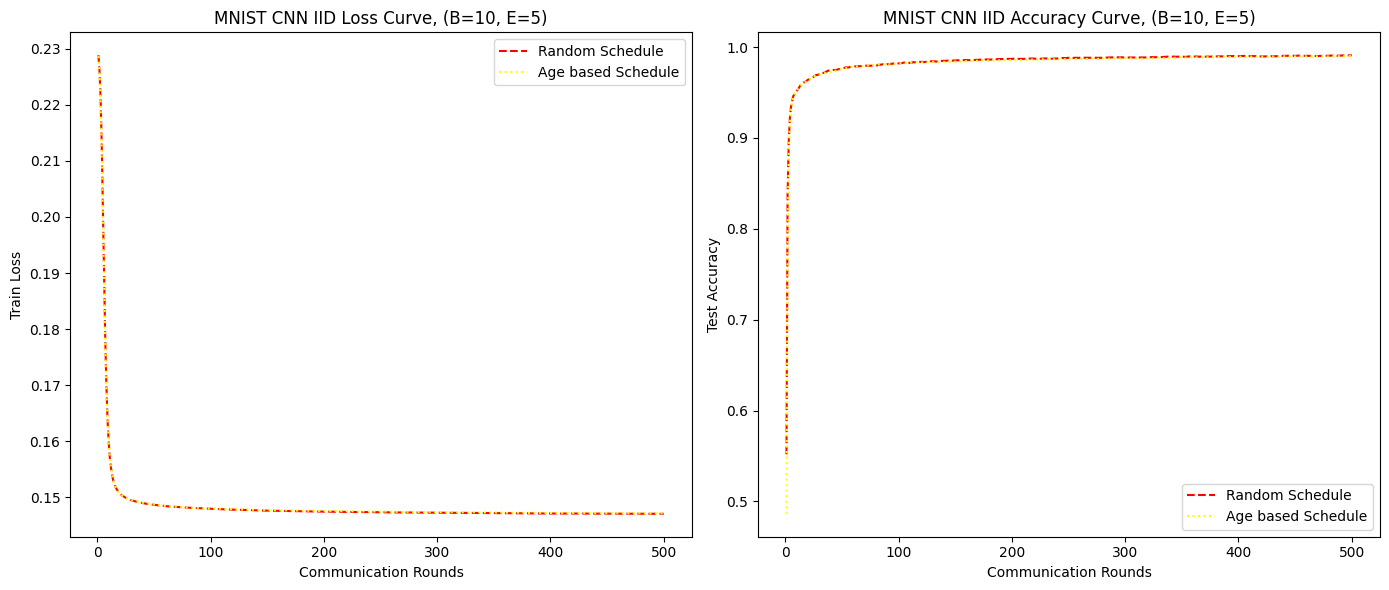

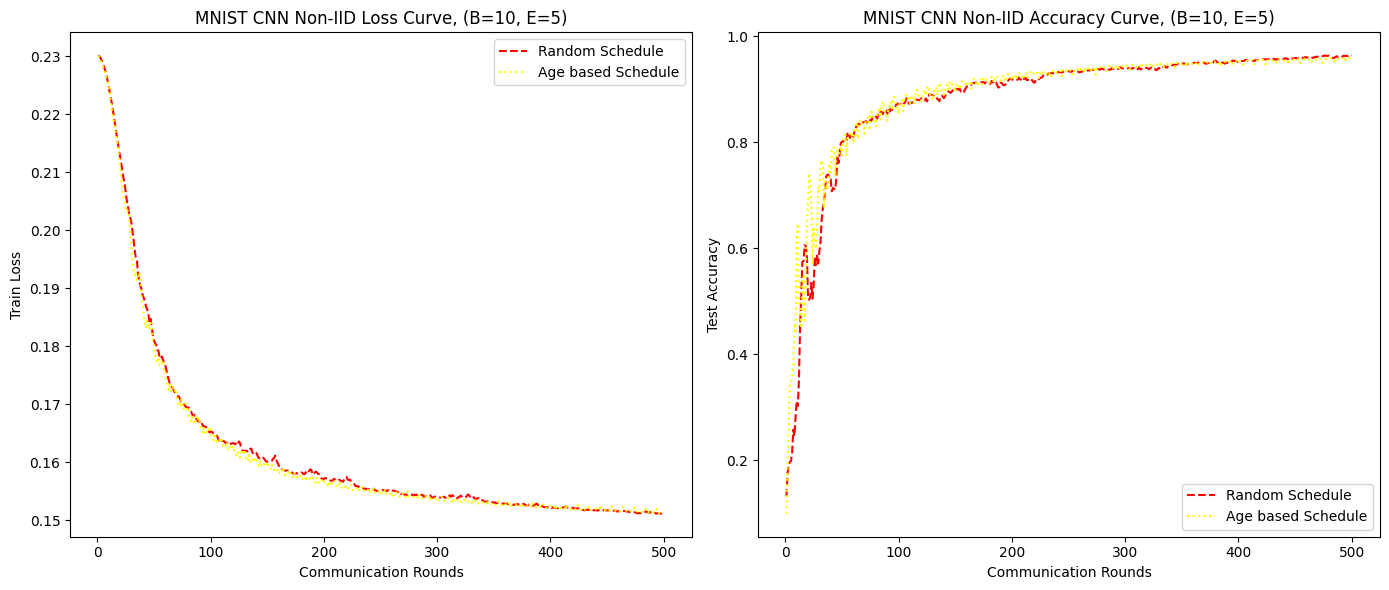

In [95]:
epochs_range = range(1, args.total_rounds + 1)

# Plot Global Training Loss for IID
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, random_losses_IID, color='red', linestyle="dashed", label="Random Schedule")
plt.plot(epochs_range, scheduled_losses_IID, color='yellow', linestyle="dotted", label="Age based Schedule")
plt.xlabel('Communication Rounds')
plt.ylabel('Train Loss')
plt.legend(loc='upper right')  
plt.title('MNIST CNN IID Loss Curve, (B=10, E=5)')

# Plot Global Validation Accuracy for IID
plt.subplot(1, 2, 2)
plt.plot(epochs_range, random_accuracies_IID, color='red', linestyle="dashed", label="Random Schedule")
plt.plot(epochs_range, scheduled_accuracies_IID, color='yellow', linestyle="dotted", label="Age based Schedule")
plt.xlabel('Communication Rounds')
plt.ylabel('Test Accuracy')
plt.legend(loc='lower right') 
plt.title('MNIST CNN IID Accuracy Curve, (B=10, E=5)')


plt.tight_layout()
plt.show()

# Plot Global Training Loss for nonIID
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, random_losses_nonIID, color='red', linestyle="dashed", label="Random Schedule")
plt.plot(epochs_range, scheduled_losses_nonIID, color='yellow', linestyle = "dotted", label="Age based Schedule")
plt.xlabel('Communication Rounds')
plt.ylabel('Train Loss')
plt.legend(loc='upper right')  
plt.title('MNIST CNN Non-IID Loss Curve, (B=10, E=5)')

# Plot Global Validation Accuracy for nonIID
plt.subplot(1, 2, 2)
plt.plot(epochs_range, random_accuracies_nonIID, color='red', linestyle="dashed", label="Random Schedule")
plt.plot(epochs_range, scheduled_accuracies_nonIID, color='yellow', linestyle="dotted", label="Age based Schedule")
plt.xlabel('Communication Rounds')
plt.ylabel('Test Accuracy')
plt.legend(loc='lower right') 
plt.title('MNIST CNN Non-IID Accuracy Curve, (B=10, E=5)')



plt.tight_layout()
plt.show()